In [5]:
import numpy as np
import tensorflow as tf
# from numpy.random import seed
# seed(1)
# from tensorflow import set_random_seed
# set_random_seed(2)



import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import os
import keras
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold 
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras import optimizers
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Bidirectional, BatchNormalization,SpatialDropout1D, Activation, GlobalAveragePooling1D, Dense, Input, Dropout, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.initializers import glorot_normal, glorot_uniform, he_uniform
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.metrics import ConfusionMatrixDisplay
import random

from sklearn.utils import class_weight
from sklearn.utils import shuffle

from keras import backend as K


%matplotlib inline

import warnings
warnings.filterwarnings('ignore')



/Users/ethan/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/ethan/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/ethan/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/ethan/opt/anaconda3/lib/python3.7/site-packages/tensorflow/pyth

# TO RUN CODE CHANGE FILE ADDRESS

In addition please note that the check point function is off currrently if you'd like to save the check point scroll down to the commented blocks uncomment them thera are two blocks that require uncommenting

In [6]:
# Load dataset
def load_data():
  data_train=pd.read_csv('/Users/ethan/py3tf/project_nlp/train_data_hs.csv')
  data_test=pd.read_csv('/Users/ethan/py3tf/project_nlp/test_data_hs.csv')
  data_val=pd.read_csv('/Users/ethan/py3tf/project_nlp/val_data_hs.csv')
  data_train=data_train.drop('Unnamed: 0', axis=1)
  data_test=data_test.drop('Unnamed: 0', axis=1)
  data_val=data_val.drop('Unnamed: 0', axis=1)
  return data_train, data_test, data_val


In [7]:
label={0:'hate', 1:'offensive', 2:'neither'}

In [8]:
# Plot data by target class
def plot(data):
  sns.countplot(data['class'])
  plt.xlabel('Class')
  plt.title('Distribution of data in each class')
  plt.ylabel('Count')
  plt.show()

 Cleaning tweets

In [9]:
data_train, data_test, data_val = load_data()


In [10]:
data_train = data_train.astype(str)
data_train = shuffle(data_train, random_state=1)


In [11]:
data_train

,class,tweet
9708,2,Nature s majesty is beautiful melts butter ...
13169,2,last thought before bed in we had a mo...
24404,1,you were team on haha bitch that our
30820,1,bitch I Rick m James
25760,0,thats just not a have a team me retard hate ba...
...,...,...
7813,1,Only negro to keep adding baby fat as they got...
32511,1,Lolalways moaning old complaining bitch the li...
5192,1,hos will literally do ANYTHING to say they g...
12172,1,Paper over pussy cause pussy Bring problems P...


In [12]:
data_val

,class,tweet
0,1,yea u know these lil bitches be stalking a...
1,2,Fit lads Nice gear these scally lads n t...
2,1,I got bad bitches on stand by
3,1,With no babymama drama side hoes all that ...
4,1,I think my wish came true where y all hat...
...,...,...
4208,1,sockin bitches in they mouf
4209,1,prairie nigger
4210,1,He s been drinking too much of that shitty ...
4211,1,Having a bitch ain t goofy Having bitch dat a...


In [13]:
print(len(data_train))
print(len(data_test))
print(len(data_val))

33704
3718
4213


In [14]:
frequency_df = data_test.groupby('class').count()
print(frequency_df)

       tweet
class       
0        199
1       2894
2        625


In [15]:
frequency_d = data_val.groupby('class').count()
print(frequency_d)

       tweet
class       
0        258
1       3276
2        679


In [16]:
# Splitting data 
def split_data(data_train, data_test, data_val ):
 
  X_train=data_train['tweet']
  y_train=data_train['class'].values
  y_train=to_categorical(y_train)

  X_test=data_test['tweet']
  y_test=data_test['class'].values
  y_test=to_categorical(y_test)

  X_val=data_val['tweet']
  y_val=data_val['class'].values
  y_val=to_categorical(y_val)

  return X_train, y_train, X_test, y_test, X_val, y_val


In [17]:
# data = load_data()
# data = clean_text(data)
X_train, y_train, X_test, y_test, X_val, y_val = split_data(data_train, data_test, data_val)


In [18]:
# Data pre-processing
#token.word_index gives me the total vocabulary of the training data
#Creating vectorizer for LSTM

def create_token(X,max_seq_len = None):
  token=Tokenizer() # Define Tokenizer
  token.fit_on_texts(X) # Train tokenizer
  word_index = token.word_index
#   X = sequence.pad_sequences(encoded, maxlen=self.max_seq_len)
  if max_seq_len is None:
    max_seq_len = max([len(s.split()) for s in X.tolist()])
  
  sequences=token.texts_to_sequences(X) # apply tokenizer on data
  pad_sequence=sequence.pad_sequences(sequences, maxlen = max_seq_len) # padding token sequernces to provide it as input
  #applying padding to ensure equal size of sequences.. length of padding matrix gives the size of input data
  return token, max_seq_len, pad_sequence, word_index

In [19]:
#Get Vectors for LSTM modeld
token, max_seq_len, X_train_pad, word_index = create_token(X_train)

In [20]:
def create_token_b(X):
  _sequences=token.texts_to_sequences(X) # apply tokenizer on data
  pad_seq=sequence.pad_sequences(_sequences, maxlen=max_seq_len) # padding token sequernces to provide it as input
  #applying padding to ensure equal size of sequences.. length of padding matrix gives the size of input data
  return token, pad_seq, word_index

__, X_test_padded, b = create_token_b(X_test)
__, X_val_padded, b = create_token_b(X_val)

In [21]:

X_test_padded.shape

(3718, 34)

In [22]:
X_val_padded.shape

(4213, 34)

In [23]:
X_train_pad.shape

(33704, 34)

# Embed LSTM Model

In [24]:

# Create embedding matrix for LSTM
def index_vector():
  embeddings_index = {}
  f = open('/Users/ethan/py3tf/project_nlp/glove.6B/glove.6B.100d.txt', encoding='utf-8')
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
  f.close()
  return embeddings_index

def create_embed_matrix(word_index, embeddings_index):
  embedding_matrix = np.zeros((len(word_index) + 1, 100))
  for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
  return embedding_matrix




In [168]:

def em_lstm_model(nb_words, embedding_matrix, max_seq_len, num_classes=3):
  model = Sequential()
  embed_dim=100
  num_filters=64
  model.add(Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
  model.add(SpatialDropout1D(0.3))
  model.add(LSTM(128, dropout = 0.5, recurrent_dropout = 0.2))
#   model.add(BatchNormalization())  
  model.add(Dense(128, activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(num_classes, activation = 'softmax'))

#   adam = optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#   SGD = optimizers.SGD(learning_rate=1e-3)
  adam = optimizers.Adam(lr=1e-5)
  model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
  model.summary()
  return model

y_train_d = np.argmax(y_train, axis=1)
clweight = class_weight.compute_class_weight('balanced', np.unique(y_train_d), y_train_d)
d_class_weights = dict(enumerate(clweight))
d_class_weights


# class_weight = {0:14., 1:1., 2:5.}
# {0: 5.773210003425831, 1: 0.4314388120839734, 2: 1.9647895534569197}

{0: 5.773210003425831, 1: 0.4314388120839734, 2: 1.9647895534569197}

In [169]:
# # , class_weight = class_weight
# def fit_model3(model, pad_sequence, callback):
#   history = model.fit(pad_sequence, y_train, validation_data = (X_val_padded, y_val), epochs = 100, batch_size = 128, callbacks = [callback], class_weight = d_class_weights)
#   return model, history

### UNCOMMENT BLOCK above TO RUN with CHECK POINT

### UNCOMMENT BLOCK below TO RUN without CHECK POINT

In [ ]:
# , class_weight = class_weight
def fit_model3(model, pad_sequence):
  history = model.fit(pad_sequence, y_train, validation_data = (X_val_padded, y_val), epochs = 100, batch_size = 128, class_weight = d_class_weights)
  return model, history

In [170]:
embeddings_index=index_vector()
embeddings_matrix=create_embed_matrix(word_index, embeddings_index)

100%|██████████| 27746/27746 [00:00<00:00, 664776.78it/s]


In [171]:
em_model = em_lstm_model(len(word_index)+1, embeddings_matrix, X_train_pad.shape[1])

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 34, 100)           2774700   
_________________________________________________________________
spatial_dropout1d_13 (Spatia (None, 34, 100)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 128)               117248    
_________________________________________________________________
dense_25 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 3)                 387       
Total params: 2,908,847
Trainable params: 134,147
Non-trainable params: 2,774,700
_____________________________________

In [173]:
# em_model, em_lstm_hist = fit_model3(em_model, X_train_pad, checkpt2)

Train on 33704 samples, validate on 4213 samples
Epoch 1/100
33704/33704 [==============================] - 19s 573us/step - loss: 1.1114 - accuracy: 0.1673 - val_loss: 1.0936 - val_accuracy: 0.3480

Epoch 00001: saving model to /Users/ethan/py3tf/_weights_hs/rs/cp-0001.ckpt
Epoch 2/100
33704/33704 [==============================] - 17s 505us/step - loss: 1.1022 - accuracy: 0.2388 - val_loss: 1.0390 - val_accuracy: 0.6620

Epoch 00002: saving model to /Users/ethan/py3tf/_weights_hs/rs/cp-0002.ckpt
Epoch 3/100
33704/33704 [==============================] - 17s 509us/step - loss: 1.0942 - accuracy: 0.3075 - val_loss: 1.0046 - val_accuracy: 0.7353

Epoch 00003: saving model to /Users/ethan/py3tf/_weights_hs/rs/cp-0003.ckpt
Epoch 4/100
33704/33704 [==============================] - 16s 487us/step - loss: 1.0871 - accuracy: 0.3712 - val_loss: 0.9807 - val_accuracy: 0.7543

Epoch 00004: saving model to /Users/ethan/py3tf/_weights_hs/rs/cp-0004.ckpt
Epoch 5/100
33704/33704 [==================

33704/33704 [==============================] - 17s 493us/step - loss: 0.9716 - accuracy: 0.5309 - val_loss: 0.7436 - val_accuracy: 0.7833

Epoch 00037: saving model to /Users/ethan/py3tf/_weights_hs/rs/cp-0037.ckpt
Epoch 38/100
33704/33704 [==============================] - 17s 493us/step - loss: 0.9649 - accuracy: 0.5396 - val_loss: 0.7418 - val_accuracy: 0.7835

Epoch 00038: saving model to /Users/ethan/py3tf/_weights_hs/rs/cp-0038.ckpt
Epoch 39/100
33704/33704 [==============================] - 17s 497us/step - loss: 0.9616 - accuracy: 0.5339 - val_loss: 0.7450 - val_accuracy: 0.7800

Epoch 00039: saving model to /Users/ethan/py3tf/_weights_hs/rs/cp-0039.ckpt
Epoch 40/100
33704/33704 [==============================] - 16s 481us/step - loss: 0.9622 - accuracy: 0.5339 - val_loss: 0.7372 - val_accuracy: 0.7833

Epoch 00040: saving model to /Users/ethan/py3tf/_weights_hs/rs/cp-0040.ckpt
Epoch 41/100
33704/33704 [==============================] - 17s 498us/step - loss: 0.9588 - accuracy:

33704/33704 [==============================] - 18s 534us/step - loss: 0.9147 - accuracy: 0.5684 - val_loss: 0.6632 - val_accuracy: 0.7925

Epoch 00073: saving model to /Users/ethan/py3tf/_weights_hs/rs/cp-0073.ckpt
Epoch 74/100
33704/33704 [==============================] - 17s 506us/step - loss: 0.9194 - accuracy: 0.5726 - val_loss: 0.6640 - val_accuracy: 0.7942

Epoch 00074: saving model to /Users/ethan/py3tf/_weights_hs/rs/cp-0074.ckpt
Epoch 75/100
33704/33704 [==============================] - 17s 510us/step - loss: 0.9165 - accuracy: 0.5742 - val_loss: 0.6602 - val_accuracy: 0.7944

Epoch 00075: saving model to /Users/ethan/py3tf/_weights_hs/rs/cp-0075.ckpt
Epoch 76/100
33704/33704 [==============================] - 17s 502us/step - loss: 0.9175 - accuracy: 0.5790 - val_loss: 0.6550 - val_accuracy: 0.7968

Epoch 00076: saving model to /Users/ethan/py3tf/_weights_hs/rs/cp-0076.ckpt
Epoch 77/100
33704/33704 [==============================] - 16s 487us/step - loss: 0.9170 - accuracy:

### UNCOMMENT BLOCK above TO RUN with CHECK POINT

### UNCOMMENT BLOCK below TO RUN without CHECK POINT

In [172]:
# checkpoint_path = '/Users/ethan/py3tf/_weights_hs/rs/cp-{epoch:04d}.ckpt'
# checkpoint_loc = os.path.dirname(checkpoint_path)
# checkpt2 = keras.callbacks.ModelCheckpoint(checkpoint_path,save_weights_only=True,verbose=1,period=1)

In [ ]:
em_model, em_lstm_hist = fit_model3(em_model, X_train_pad)

In [84]:
# em_model.load_weights(checkpoint_path)

In [174]:
def plot_model(lstm_hist):
    
    # summarize history for accuracy
  plt.plot(lstm_hist.history['accuracy'])
  plt.plot(lstm_hist.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
# summarize history for loss
  plt.plot(lstm_hist.history['loss'])
  plt.plot(lstm_hist.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
#   plt.figure(figsize=(10, 6))
#   plt.subplot(1, 2, 1)
#   plt.title('Accuracy')
#   plt.plot(np.arange(1, 11), lstm_hist.history['accuracy'], label='Training accuracy')
#   plt.plot(np.arange(1, 11), lstm_hist.history['val_accuracy'], label='Val_accuracy')
#   plt.xlabel('Epochs')
#   plt.ylabel('Accuracy')
#   plt.legend()

#   plt.subplot(1, 2, 2)
#   plt.title('Loss')
#   plt.plot(np.arange(1, 11), lstm_hist.history['loss'], label='Training loss')
#   plt.plot(np.arange(1, 11), lstm_hist.history['val_loss'],label='Val_loss')
#   plt.xlabel('Epochs')
#   plt.ylabel('Loss')
#   plt.legend()

  plt.show()

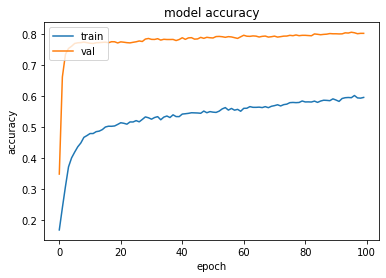

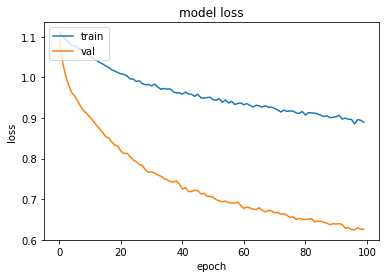

In [175]:
plot_model(em_lstm_hist)

In [3]:
model_cm = em_lstm_model(len(word_index)+1, embeddings_matrix, X_train_pad.shape[1])

NameError: name 'em_lstm_model' is not defined

In [4]:
model_cm.load_weights(os.path.join(checkpoint_loc,'cp-0097.ckpt'))

NameError: name 'model_cm' is not defined

## check model accuracy

In [1]:
def check_accuracy(model, X_test, y_test):
  test_sequences=token.texts_to_sequences(X_test)
  test_pad=sequence.pad_sequences(test_sequences, maxlen=max_seq_len)
  y_pred = model.predict(test_pad)
  acc=model.evaluate(test_pad, y_test)
  print("Accuracy: {}".format(acc[1]))
  y_test_=np.argmax(y_test, axis=1)
  y_pred=np.argmax(y_pred, axis=1)
  print(metrics.classification_report(y_test_, y_pred))
  cm = confusion_matrix(y_test_, y_pred, normalize='true')
  
  np.set_printoptions(precision=2)
  # cm = confusion_matrix(y_test, y_pred)gist_gray_r

  cm_display = ConfusionMatrixDisplay(cm, display_labels=label.values()).plot(cmap=plt.cm.Blues)

In [2]:
print("HS_RS_LSTM accuracy hs_rs: ")
check_accuracy(model_cm, X_test, y_test)

HS_RS_LSTM accuracy hs_rs: 


NameError: name 'model_cm' is not defined

In [180]:
model_n = em_lstm_model(len(word_index)+1, embeddings_matrix, X_train_pad.shape[1])

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 34, 100)           2774700   
_________________________________________________________________
spatial_dropout1d_15 (Spatia (None, 34, 100)           0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 128)               117248    
_________________________________________________________________
dense_29 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 3)                 387       
Total params: 2,908,847
Trainable params: 134,147
Non-trainable params: 2,774,700
_____________________________________

## Evaluate on test_data per epoch (Precision, Recall, F1_Score, Accuracy)

In [181]:
list_checkpoint = []
for files in sorted(os.listdir(checkpoint_loc)):
    if files.endswith(".ckpt"):
        list_checkpoint.append(files)
precision_checkpoints = []
recall_checkpoints = []
f1_checkpoints = []
accuracy_checkpoints = []
loss_checkpoints = []
for ckpt_name in list_checkpoint:
    model_n.load_weights(os.path.join(checkpoint_loc,ckpt_name))
    acc=model_n.evaluate(X_test_padded, y_test, verbose = 0)
    accuracy_checkpoints.append(acc[1]*100)
    loss_checkpoints.append(acc[0]*100)
    y_pred = model_n.predict(X_test_padded)
    y_pred_ = np.argmax(y_pred, axis=1)
    y_test_= np.argmax(y_test, axis=1)
    # Print f1, precision, and recall scores
    precision = precision_score(y_test_, y_pred_ , average="macro")*100
    precision_checkpoints.append(precision)
    recall = recall_score(y_test_, y_pred_ , average="macro")*100
    recall_checkpoints.append(recall)
    f1 = (2*(precision*recall)/(precision+recall))
    f1_checkpoints.append(f1)
    print('Scores for ',ckpt_name)
    print('Pre: ',precision,'  Rec: ', recall,'  F1: ',f1,'  Acc: ',acc[1]*100,'  Loss: ',acc[0]*100)

Scores for  cp-0001.ckpt
Pre:  38.94183874069021   Rec:  40.221393815425905   F1:  39.57127523249678   Acc:  34.26573574542999   Loss:  109.47363808181993
Scores for  cp-0002.ckpt
Pre:  43.09061136219094   Rec:  43.24341884497354   F1:  43.166879872279246   Acc:  67.42872595787048   Loss:  103.92429861989055
Scores for  cp-0003.ckpt
Pre:  45.91350148474415   Rec:  42.552261607507695   F1:  44.169026710552174   Acc:  73.58794808387756   Loss:  100.43143846451305
Scores for  cp-0004.ckpt
Pre:  48.4428124331833   Rec:  42.94089854941605   F1:  45.526229385405614   Acc:  75.68585276603699   Loss:  98.0186103524028
Scores for  cp-0005.ckpt
Pre:  48.84681738721827   Rec:  43.05087557112908   F1:  45.76607289447271   Acc:  76.7348051071167   Loss:  96.15323106212729
Scores for  cp-0006.ckpt
Pre:  50.313426042603126   Rec:  44.62707261254441   F1:  47.29996048461651   Acc:  77.24583148956299   Loss:  95.29344298109821
Scores for  cp-0007.ckpt
Pre:  51.52967449479077   Rec:  45.548504466585406 

Scores for  cp-0055.ckpt
Pre:  59.986052404326884   Rec:  65.05754239985923   F1:  62.4189532267674   Acc:  80.39268255233765   Loss:  68.04704521214083
Scores for  cp-0056.ckpt
Pre:  60.11561584952695   Rec:  64.95938990043514   F1:  62.44371056645557   Acc:  80.55406212806702   Loss:  67.64568496673834
Scores for  cp-0057.ckpt
Pre:  60.446969509631785   Rec:  65.26109719294469   F1:  62.76185221304007   Acc:  80.82302212715149   Loss:  67.56485472961803
Scores for  cp-0058.ckpt
Pre:  60.112626787722334   Rec:  65.05478167154594   F1:  62.486135320936754   Acc:  80.6078553199768   Loss:  67.44639104960618
Scores for  cp-0059.ckpt
Pre:  60.17032771366492   Rec:  65.60211340045076   F1:  62.76892818566941   Acc:  80.50026893615723   Loss:  67.7298836454132
Scores for  cp-0060.ckpt
Pre:  60.550963645569944   Rec:  65.46291244288709   F1:  62.91120556723317   Acc:  80.90370893478394   Loss:  66.83722282366575
Scores for  cp-0061.ckpt
Pre:  60.58021078869652   Rec:  65.1857376724674   F1: 

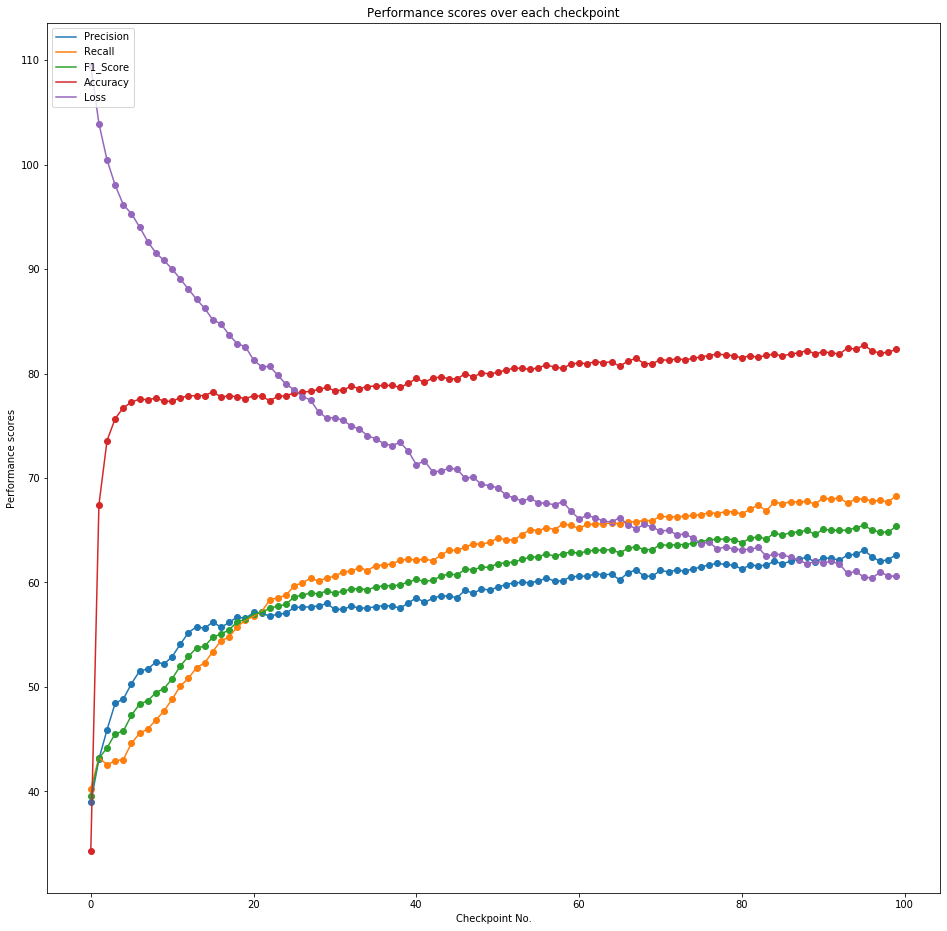

In [182]:
plt.figure(figsize=(16,16))
plt.plot(precision_checkpoints)
plt.scatter(range(0,100),precision_checkpoints)
plt.plot(recall_checkpoints)
plt.scatter(range(0,100),recall_checkpoints)
plt.plot(f1_checkpoints)
plt.scatter(range(0,100),f1_checkpoints)
plt.plot(accuracy_checkpoints)
plt.scatter(range(0,100),accuracy_checkpoints)
plt.plot(loss_checkpoints)
plt.scatter(range(0,100),loss_checkpoints)
plt.title('Performance scores over each checkpoint')
plt.ylabel('Performance scores')
plt.xlabel('Checkpoint No.')
plt.legend(['Precision', 'Recall','F1_Score','Accuracy', 'Loss'], loc='upper left')
#plt.ylim(0, 100)
plt.show()


## Evaluate on validation_data per epoch (Precision, Recall, F1_Score, Accuracy)

In [183]:
list_checkpoint = []
for files in sorted(os.listdir(checkpoint_loc)):
    if files.endswith(".ckpt"):
        list_checkpoint.append(files)
precision_checkpoints_va = []
recall_checkpoints_va = []
f1_checkpoints_va = []
accuracy_checkpoints_va = []
loss_checkpoints_va = []
for ckpt_name in list_checkpoint:
    model_n.load_weights(os.path.join(checkpoint_loc,ckpt_name))
    acc_va=model_n.evaluate(X_val_padded, y_val, verbose = 0)
    accuracy_checkpoints_va.append(acc_va[1]*100)
    loss_checkpoints_va.append(acc_va[0]*100)
    y_pred_va = model_n.predict(X_val_padded)
    y_pred_va = np.argmax(y_pred_va, axis=1)
    y_val_= np.argmax(y_val, axis=1)
    # Print f1, precision, and recall scores
    precision_va = precision_score(y_val_, y_pred_va , average="macro")*100
    precision_checkpoints_va.append(precision_va)
    recall_va = recall_score(y_val_, y_pred_va , average="macro")*100
    recall_checkpoints_va.append(recall_va)
    f1_va = (2*(precision_va*recall_va)/(precision_va+recall_va))
    f1_checkpoints_va.append(f1_va)
    print('Scores for ',ckpt_name)
    print('Pre_va: ',precision_va,'  Rec_va: ', recall_va,' F1_va: ',f1_va,'  Acc_va: ',acc_va[1]*100,'  Loss_va: ',acc_va[0]*100)


Scores for  cp-0001.ckpt
Pre_va:  39.812572400846655   Rec_va:  40.560603297357076  F1_va:  40.183106897793955   Acc_va:  34.7970575094223   Loss_va:  109.35528967631222
Scores for  cp-0002.ckpt
Pre_va:  42.30955084888194   Rec_va:  40.41195447333064  F1_va:  41.33898763162285   Acc_va:  66.19985699653625   Loss_va:  103.89546018978946
Scores for  cp-0003.ckpt
Pre_va:  44.89649235886107   Rec_va:  41.07017102701591  F1_va:  42.898178132489036   Acc_va:  73.53429794311523   Loss_va:  100.46196981306007
Scores for  cp-0004.ckpt
Pre_va:  45.895244431505084   Rec_va:  40.73966981543102  F1_va:  43.16405505772499   Acc_va:  75.43318271636963   Loss_va:  98.07374164295854
Scores for  cp-0005.ckpt
Pre_va:  47.10952008853297   Rec_va:  41.6675887845871  F1_va:  44.22176247468622   Acc_va:  76.14526748657227   Loss_va:  96.23144979067209
Scores for  cp-0006.ckpt
Pre_va:  48.51860104573776   Rec_va:  43.41177971002953  F1_va:  45.823345952023324   Acc_va:  77.04723477363586   Loss_va:  95.369714

Scores for  cp-0050.ckpt
Pre_va:  56.87078982083711   Rec_va:  60.05513484535302  F1_va:  58.419601319427194   Acc_va:  78.89864444732666   Loss_va:  70.67187480396821
Scores for  cp-0051.ckpt
Pre_va:  56.93495950967197   Rec_va:  60.37940810177683  F1_va:  58.60661785056813   Acc_va:  78.82744073867798   Loss_va:  70.46876595701086
Scores for  cp-0052.ckpt
Pre_va:  57.26558724857787   Rec_va:  59.9455174676944  F1_va:  58.57491521843543   Acc_va:  79.27842140197754   Loss_va:  69.85128526022109
Scores for  cp-0053.ckpt
Pre_va:  57.30155092208206   Rec_va:  59.77128353057387  F1_va:  58.5103668655164   Acc_va:  79.32589650154114   Loss_va:  69.56895621378065
Scores for  cp-0054.ckpt
Pre_va:  57.20513058305542   Rec_va:  60.119751404814934  F1_va:  58.62623804026201   Acc_va:  79.23095226287842   Loss_va:  69.30093675986227
Scores for  cp-0055.ckpt
Pre_va:  57.20263324684836   Rec_va:  60.62892394107929  F1_va:  58.86596397637946   Acc_va:  79.04106378555298   Loss_va:  69.5307579398183

Scores for  cp-0099.ckpt
Pre_va:  60.03338651662759   Rec_va:  64.26162944383994  F1_va:  62.07559022024407   Acc_va:  80.32280802726746   Loss_va:  62.61560752361822
Scores for  cp-0100.ckpt
Pre_va:  60.13674840704789   Rec_va:  64.49967735630646  F1_va:  62.24185017751708   Acc_va:  80.32280802726746   Loss_va:  62.542440125587405


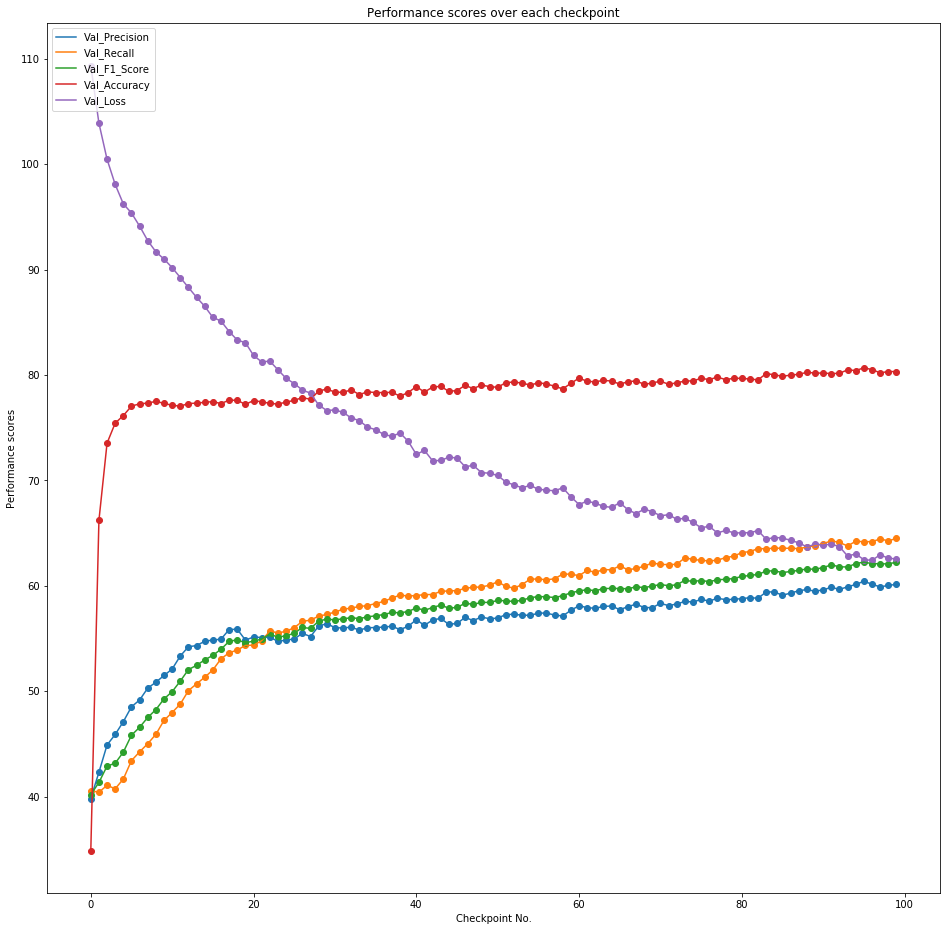

In [184]:
plt.figure(figsize=(16,16))
plt.plot(precision_checkpoints_va)
plt.scatter(range(0,100),precision_checkpoints_va)
plt.plot(recall_checkpoints_va)
plt.scatter(range(0,100),recall_checkpoints_va)
plt.plot(f1_checkpoints_va)
plt.scatter(range(0,100),f1_checkpoints_va)
plt.plot(accuracy_checkpoints_va)
plt.scatter(range(0,100),accuracy_checkpoints_va)
plt.plot(loss_checkpoints_va)
plt.scatter(range(0,100),loss_checkpoints_va)
plt.title('Performance scores over each checkpoint')
plt.ylabel('Performance scores')
plt.xlabel('Checkpoint No.')
plt.legend(['Val_Precision', 'Val_Recall','Val_F1_Score','Val_Accuracy', 'Val_Loss'], loc='upper left')
#plt.ylim(0, 100)
plt.show()


## Save test evaluation metric scores

In [185]:
pre = precision_checkpoints
rec = recall_checkpoints
f1_sc = f1_checkpoints
accu = accuracy_checkpoints
los = loss_checkpoints
s1=pd.Series(pre,name='Precision_test')
s2=pd.Series(rec,name='Recall_test')
s3=pd.Series(f1_sc,name='F1_Score_test')
s4=pd.Series(accu,name='Accuracy_test')
s5=pd.Series(los,name='Loss_test')
Base_test_values = pd.concat([s1,s2,s3,s4,s5], axis=1)

Base_test_values=Base_test_values[0:100]
Base_test_values

,Precision_test,Recall_test,F1_Score_test,Accuracy_test,Loss_test
0,38.941839,40.221394,39.571275,34.265736,109.473638
1,43.090611,43.243419,43.166880,67.428726,103.924299
2,45.913501,42.552262,44.169027,73.587948,100.431438
3,48.442812,42.940899,45.526229,75.685853,98.018610
4,48.846817,43.050876,45.766073,76.734805,96.153231
...,...,...,...,...,...
95,63.099194,68.014836,65.464868,82.705754,60.508302
96,62.464235,67.795993,65.020995,82.194728,60.436902
97,62.015546,67.859348,64.805974,81.925768,60.975755
98,62.193500,67.707862,64.833638,82.060248,60.645552


In [186]:
Base_test_values.to_csv('/Users/ethan/py3tf/_RS_test_values_100epochs.csv')


## Save validation evaluation metric scores

In [187]:
pre_va = precision_checkpoints_va
rec_va = recall_checkpoints_va
f1_sc_va = f1_checkpoints_va
accu_va = accuracy_checkpoints_va
los_va = loss_checkpoints_va
s1=pd.Series(pre_va,name='Precision_val')
s2=pd.Series(rec_va,name='Recall_val')
s3=pd.Series(f1_sc_va,name='F1_Score_val')
s4=pd.Series(accu_va,name='Accuracy_val')
s5=pd.Series(los_va,name='Loss_val')
Base_val_values = pd.concat([s1,s2,s3,s4,s5], axis=1)

Base_val_values=Base_val_values[0:100]
Base_val_values

,Precision_val,Recall_val,F1_Score_val,Accuracy_val,Loss_val
0,39.812572,40.560603,40.183107,34.797058,109.355290
1,42.309551,40.411954,41.338988,66.199857,103.895460
2,44.896492,41.070171,42.898178,73.534298,100.461970
3,45.895244,40.739670,43.164055,75.433183,98.073742
4,47.109520,41.667589,44.221762,76.145267,96.231450
...,...,...,...,...,...
95,60.431235,64.178480,62.248515,80.678850,62.473412
96,60.144160,64.185089,62.098956,80.512697,62.414650
97,59.895381,64.446529,62.087665,80.204129,62.946183
98,60.033387,64.261629,62.075590,80.322808,62.615608


In [188]:
Base_val_values.to_csv('/Users/ethan/py3tf/_RS_val_values_100epochs.csv')